%%latem
\tableofcontents

# Preparations

In [216]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pywt
# for visualisation purposes
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

In [5]:
# ENV_NAME = 'colab'
ENV_NAME = 'local'
path_prefix = {'colab': '/content/drive/MyDrive/ComputerVision/CV-Phase1/', 
                'local': './Images/'}

Open image using pyplot:

In [6]:
def loadImage(name, path_prefix=path_prefix[ENV_NAME]):
  image = plt.imread(path_prefix + name)
  print(image.shape)
  print(type(image))
  return image

In [7]:
plt.gray()

<Figure size 432x288 with 0 Axes>

(450, 800, 3)
<class 'numpy.ndarray'>


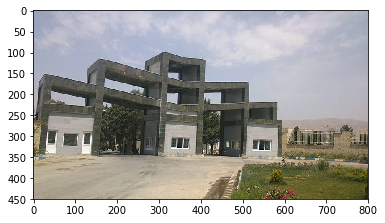

In [8]:
fimg = loadImage('fimg.jpg')
plt.imshow(fimg)

(450, 800)
<class 'numpy.ndarray'>


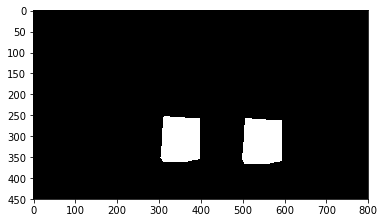

In [9]:
fimg_mask = loadImage('fimg_mask.png')
plt.imshow(fimg_mask)

In [10]:
def rgb2grey(img):
  return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])

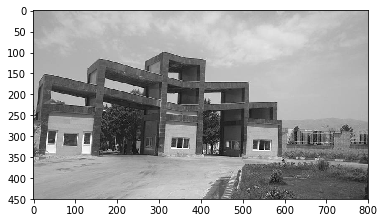

In [482]:
fimg_grey = rgb2grey(fimg)
plt.imshow(fimg_grey)

# Copy-Move Forgery Detection

To better illustrate what we're after, we illustrate the copied blocks on the mask.

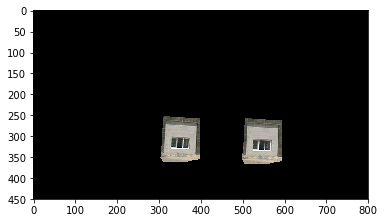

In [12]:
masked = np.zeros(fimg.shape, dtype=np.uint8)
masked[fimg_mask == 1] = fimg[fimg_mask == 1]
plt.imshow(masked)

**Step 1:** Performing a multilevel wavelet transform on the image.

Note that the axes used in `pywt` are inverted in comparison to the axes used in `numpy` and follows the conventional coordinate system. As such, what is here labelled as vertical is in accordance to the `pywt` system and `numpy` considers it as horizontal.

In [193]:
def wavelet_reconstruct(img, maxL=3, labelL=3):
    shape = (img.shape[1], img.shape[0])
    arrs = []
    arrslices = []
    fig, axs = plt.subplots(2, 4, figsize=[18, 6])
    for level in range(0, maxL + 1):
        if level == 0:
            axs[0, 0].set_axis_off()
            axs[1, 0].imshow(img)
            axs[1, 0].set_title('Original')
            axs[1, 0].set_axis_off()
            continue
        # plot subband boundaries of a standard DWT basis
        draw_2d_wp_basis(shape, wavedec2_keys(level), ax=axs[0, level],
                        label_levels=labelL)
        axs[0, level].set_title(f'Level {level}')
        # compute the 2D DWT
        c = pywt.wavedec2(img, 'haar', mode='periodization', level=level)
        # normalize each array for better visibility
        c[0] /= np.abs(c[0]).max()
        for detlevel in range(level):
            c[detlevel + 1] = [d / np.abs(d).max() for d in c[detlevel + 1]]
        arr, slices = pywt.coeffs_to_array(c)
        arrs.append(arr)
        arrslices.append(slices)
        axs[1, level].imshow(arr)
        axs[1, level].set_title(f'Coefficients\n(Level {level})')
        axs[1, level].set_axis_off()
    return fig, (arrs, arrslices)

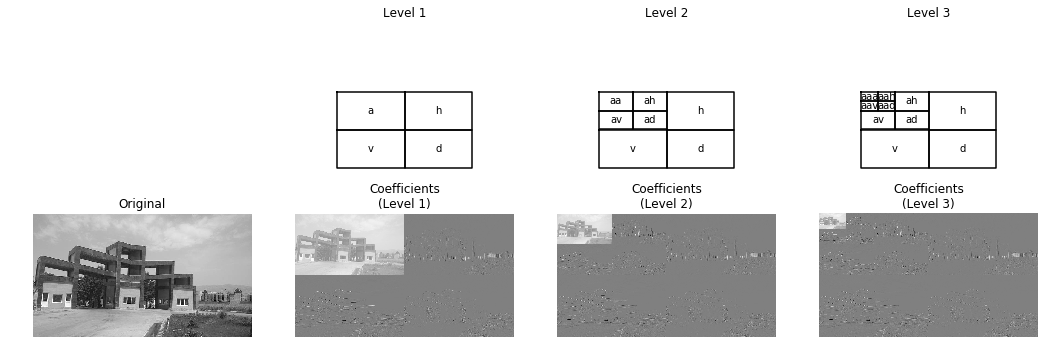

In [194]:
fig, (coeffs, coeffslices) = wavelet_reconstruct(fimg_grey, 3, 3)
plt.show()

The fading effect on the approximation coefficients is due to normalising used to better illustrate the details on the coefficients.

In [102]:
# to get an idea what we're dealing with on the output
print(coeffslices[1])

[(slice(None, 113, None), slice(None, 200, None)), {'ad': (slice(None, 113, None), slice(200, 400, None)), 'da': (slice(113, 226, None), slice(None, 200, None)), 'dd': (slice(113, 226, None), slice(200, 400, None))}, {'ad': (slice(None, 225, None), slice(400, 800, None)), 'da': (slice(226, 451, None), slice(None, 400, None)), 'dd': (slice(226, 451, None), slice(400, 800, None))}]


**Step 2:**	 Segmenting the image into smaller overlapping portions and checking for the presence of the copied blocks.

In [411]:
def get_blocks(img, r):
    h, w = img.shape
    blocks = []
    for i in range(r, h-r, r):
        for j in range(r, w-r, r):
            blocks.append(img[i-r:i+r, j-r:j+r])
    return blocks

8 blocks


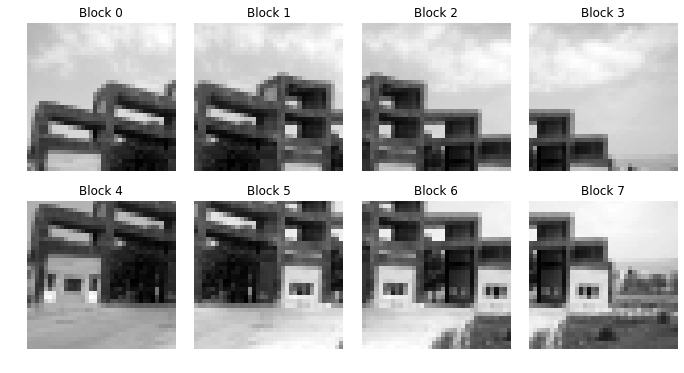

In [412]:
# divide LL2 into overlapping blocks of fixed size 
blocks = get_blocks(coeffs[2][coeffslices[2][0]], r=18)
print(f'{len(blocks)} blocks')
# and show the first 8
fig, axs = plt.subplots(2, 4, figsize=[12, 6])
plt.subplots_adjust(wspace=0)
for i, block in enumerate(blocks[:8]):
    axs[i//4, i%4].imshow(block)
    axs[i//4, i%4].set_title(f'Block {i}')
    axs[i//4, i%4].set_axis_off()
plt.show()

Of course, blocks will have to be much smaller for detection purposes. No problem!

In [440]:
l2shape = coeffs[2][coeffslices[2][0]].shape
r2 = 8
l2blocks = get_blocks(coeffs[2][coeffslices[2][0]], r=r2)
print(f'{len(l2blocks)} blocks')

66 blocks


**Step 3:**	 Selecting blocks with higher contrast than `threshold`.

In [445]:
# calculate contrast for each block
def get_high_contrast(blocks, threshold=0.5):
    hicontrasts = {}
    for i, block in enumerate(blocks):
        contrast = np.abs(block).max() - np.abs(block).min()
        if (contrast > threshold):
            hicontrasts[i] = contrast
            # print(f'Contrast {contrast} on block {i}')
    print(f'number of blocks above threshold: {len(hicontrasts)}')
    return hicontrasts

In [446]:
hicontrasts = get_high_contrast(l2blocks, threshold=0.5)

number of blocks above threshold: 53


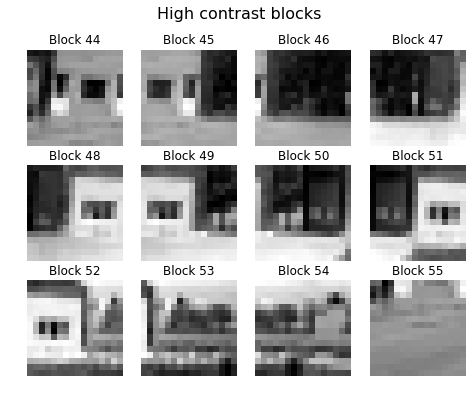

In [447]:
fig, axs = plt.subplots(3, 4, figsize=[8, 6])
plt.subplots_adjust(wspace=0.1, hspace=0.2)
fig.suptitle('High contrast blocks', fontsize=16)
for i, key in enumerate(list(hicontrasts.keys())[32:44]):
    block = l2blocks[key]
    axs[i//4, i%4].imshow(block)
    axs[i//4, i%4].set_axis_off()
    axs[i//4, i%4].set_title(f'Block {key}')
plt.show()

**Step 4:**	 Calculating phase correlation between each pair of blocks, storing ones with high correlation in a list.

In [448]:
def phase_correlation(img1, img2):
    fimg1 = np.fft.fft2(img1)
    fimg2 = np.fft.fft2(img2)
    R = fimg1 * fimg2.conjugate()
    R /= np.absolute(R)
    r = np.fft.ifft2(R).real
    return r

The correlation between a block with itself is a black image, with a peak at the point where images start to match, here the very first pixel.

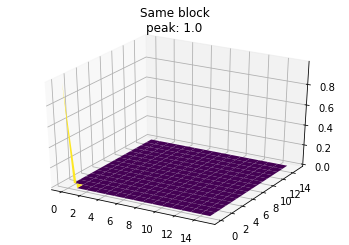

In [322]:
pc = phase_correlation(l2blocks[10], l2blocks[10])
ax = plt.axes(projection='3d')
(X, Y) = np.meshgrid(range(pc.shape[0]), range(pc.shape[1]))
ax.plot_surface(X, Y, pc, cmap='viridis')
ax.set_title(f'Same block\npeak: {pc.max()}')
plt.show()

Similarly, using the templates from the previous step, the correlation between two of the copied blocks has a peak around the start of copied segment. To verify this rationale, plotting the correlation between two adjacent blocks (sharing same data only translated to second half of the image), shows a peak at the point of translation.

For two completely different images, the correlation has no sizable peak.

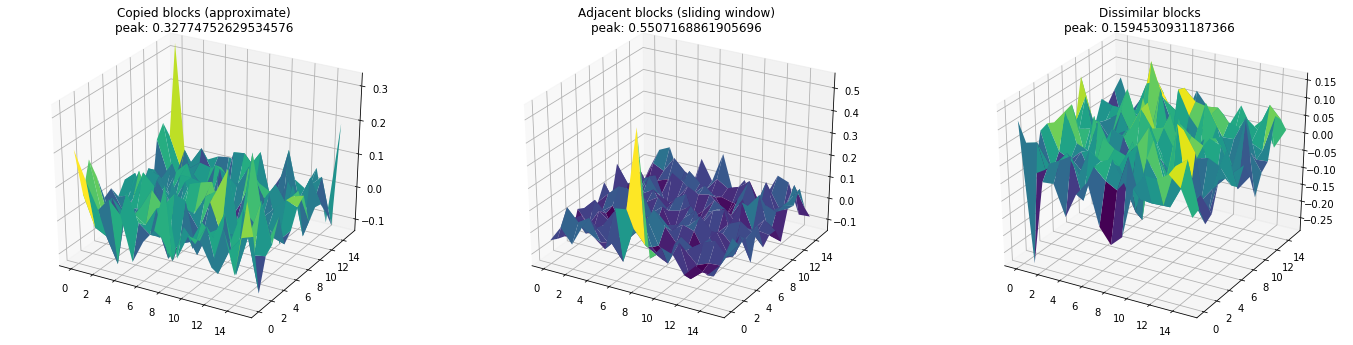

In [449]:
fig, axs = plt.subplots(1, 3, figsize=[24, 6], subplot_kw={"projection": "3d"})

pc1 = phase_correlation(l2blocks[48], l2blocks[51])
peak = (pc1).max()
(X, Y) = np.meshgrid(range(pc1.shape[0]), range(pc1.shape[1]))
axs[0].plot_surface(X, Y, pc1, cmap='viridis')
axs[0].set_title(f'Copied blocks (approximate)\npeak: {peak}')

pc2 = phase_correlation(l2blocks[48], l2blocks[49])
peak = (pc2).max()
(X, Y) = np.meshgrid(range(pc2.shape[0]), range(pc2.shape[1]))
axs[1].plot_surface(X, Y, pc2, cmap='viridis')
axs[1].set_title(f'Adjacent blocks (sliding window)\npeak: {peak}')

pc3 = phase_correlation(l2blocks[42], l2blocks[51])
peak = (pc3).max()
(X, Y) = np.meshgrid(range(pc3.shape[0]), range(pc3.shape[1]))
axs[2].plot_surface(X, Y, pc3, cmap='viridis')
axs[2].set_title(f'Dissimilar blocks\npeak: {peak}')

plt.show()

Given this, the candidacy for a match is based on the ${argmax}$ in the correlation image.

In [493]:
similars = {}
for i, key1 in enumerate(list(hicontrasts.keys())[:-1]):
    block = l2blocks[key1]
    for j, key2 in enumerate(list(hicontrasts.keys())[i+2:]):
        block2 = l2blocks[key2]
        pc = phase_correlation(block, block2)
        peak = (pc).max()
        # the second part is for omitting vertical and diagonal neighbours
        if peak > 0.325 \
                and key1 != key2 - (l2shape[1]//r2 - 1) \
                and key1 != key2 - (l2shape[1]//r2) \
                and key1 != key2 - (l2shape[1]//r2 + 1):
            similars[key1, key2] = peak
            # print(f'{key1} is similar to {key2}')
print(len(similars), 'similar blocks found')


39 similar blocks found


**Step 5:**	 Verifying the similarities on higher levels. Phase correlations in `similars` are verified to be above the threshold in the larger blocks of the same scene (resolution is higher, but the scene has not changed).

Size of the blocks are multiplied by a factor of 2 to obtain the same blocks.

In [494]:
r1 = r2*2
l1shape = coeffs[1][coeffslices[1][0]].shape
l1blocks = get_blocks(coeffs[1][coeffslices[1][0]], r=r1)
print(f'{len(blocks)} blocks')

66 blocks


In [495]:
l1similars = {}
for i, key in enumerate(list(similars.keys())):
    block1 = l1blocks[key[0]]
    block2 = l1blocks[key[1]]
    pc = phase_correlation(block1, block2)
    peak = (pc).max()
    if peak >= similars[key]:
        l1similars[key] = peak
        # print(f'{key[0]} is similar to {key[1]}')
print(len(l1similars), 'similar blocks found')

1 similar blocks found


The number of similar blocks was reduced by about 1/3. The next step will be on LL0 (the least compressed).

In [496]:
r0 = r1*2
l0shape = coeffs[0][coeffslices[0][0]].shape
l0blocks = get_blocks(coeffs[0][coeffslices[0][0]], r=r0)
print(f'{len(blocks)} blocks')

66 blocks


In [498]:
l0similars = {}
for i, key in enumerate(list(l1similars.keys())):
    block1 = l0blocks[key[0]]
    block2 = l0blocks[key[1]]
    pc = phase_correlation(block1, block2)
    peak = (pc).max()
    if peak >= 0.18:
        l0similars[key] = peak
        # print(f'{key[0]} is similar to {key[1]}')
print(len(l0similars), 'similar blocks found')

1 similar blocks found


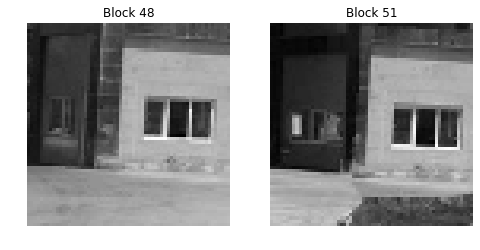

In [499]:
fig, axs = plt.subplots(1, 2, figsize=[8, 4])

block1 = l0blocks[key[0]]
block2 = l0blocks[key[1]]
pc = phase_correlation(block1, block2)
peak = (pc).max()
axs[0].imshow(block1)
axs[0].set_axis_off()
axs[0].set_title(f'Block {key[0]}')
axs[1].imshow(block2)
axs[1].set_axis_off()
axs[1].set_title(f'Block {key[1]}')
plt.show()

Which are the forged copy move blocks!